In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_32965/3546024755.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('/Users/sachacollinson/Downloads/fake_transactional_data_24.csv')
df = df.rename(columns={"from_totally_fake_account": "AccountNumber", "monopoly_money_amount": "MoneyTransferAmount", "to_randomly_generated_account": "TransferredLocationAccount", "not_happened_yet_date": "TransactionDate"})
# from_totally_fake_account  = AccountNumber
# monopoly_money_amount = MoneyTransferAmount
# to_randomly_generated_account = TransferredLocationAccount
# not_happened_yet_date = TransactionDate
df_NonNumeric_Mapping = pd.read_excel('/Users/sachacollinson/Downloads/Location_value_pairs.xlsx')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format="%d/%m/%Y").dt.date
df = df.sort_values(by=['TransactionDate'])

df_Transferred_numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric())].copy()
df_Transferred_Non_Numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric()==False)].copy()

In [3]:
df_NonNumeric_Mapping['Key'] = df_NonNumeric_Mapping['Key'].str.strip()
mapping_dict = df_NonNumeric_Mapping.to_dict(orient='records')
mapped_dict = {entry['Key']: entry['Value'] for entry in mapping_dict}

# # Create a new column by mapping values from the 'key' column using the mapping dictionary
df_Transferred_Non_Numeric['CategoryTransferredLocationAccount'] = df_Transferred_Non_Numeric['TransferredLocationAccount'].map(mapped_dict)

# # Print the DataFrame with the new column
print(len(df_Transferred_numeric))
print(len(df_Transferred_Non_Numeric))
print(len(df))

frames = [df_Transferred_Non_Numeric,df_Transferred_numeric]
df2 = pd.concat(frames)
df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)
print(df2)

2532763
7615517
10148280
          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
13385           98994.0                 2.65                COFFEE_SHOP   
13384           98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
13383           34189.0                14.50                        BAR   
13382           86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10137320        41950.0                 6.00                      21887   
10137322         8097.0                 5.00                      84802   
10137336        99012.0                 6.50                      27845   
10137340        60186.0                 2.65                      35802   
10137248        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  
0           

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_32965/3330740510.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)


In [6]:
# Ensure TransactionDate is in datetime format
df2['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm = df2.groupby('AccountNumber').agg({
    'AccountNumber': 'count',
    'MoneyTransferAmount': 'sum'
}).rename(columns={'AccountNumber': 'Frequency',
                   'MoneyTransferAmount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm['M_Score'] = rfm['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm['RFM_Score'] =  rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm.head())

               Frequency  MonetaryValue  F_Score  M_Score RFM_Score
AccountNumber                                                      
1000.0              1710       28698.51        1        3        13
1002.0              1043       15622.97        3        1        31
1006.0              1841       18778.19        1        2        12
1018.0               805       15612.21        4        1        41
1053.0              1319       19444.57        2        2        22


In [7]:
rfm.describe()

,Frequency,MonetaryValue,F_Score,M_Score
count,8142.000000,8142.000000,8142.000000,8142.000000
mean,1246.411201,22925.845676,2.501474,2.500000
std,346.909076,6811.697500,1.118212,1.118213
min,436.000000,8079.130000,1.000000,1.000000
25%,989.000000,17699.610000,2.000000,1.250000
50%,1154.000000,21021.590000,3.000000,2.500000
75%,1500.000000,28918.547500,4.000000,3.750000
max,2728.000000,45141.370000,4.000000,4.000000


In [8]:
# Count the number of customers in each segment
rfm_count = rfm['RFM_Score'].value_counts().reset_index()
rfm_count.columns = ['RFM_Score', 'Count']

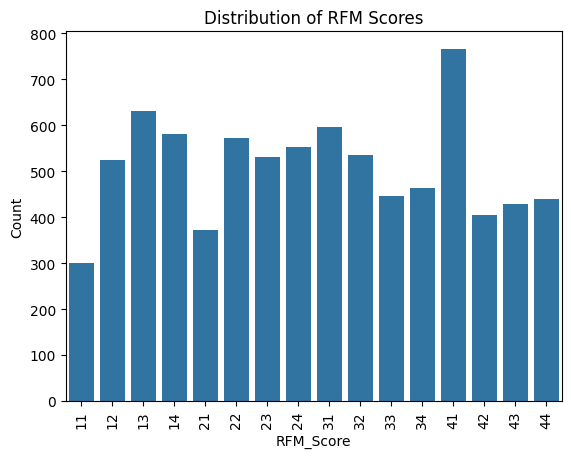

In [9]:
# Plotting the distribution of customers across RFM scores
sns.barplot(x='RFM_Score', y='Count', data=rfm_count.sort_values('RFM_Score'))
plt.title('Distribution of RFM Scores')
plt.xticks(rotation=90)  # Rotates labels to make them readable
plt.show()

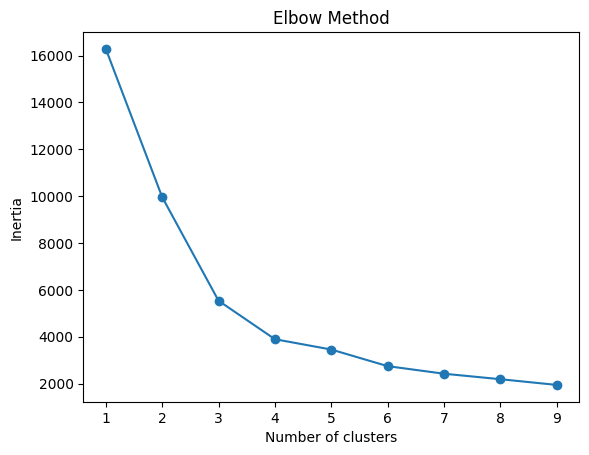

In [10]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[[ 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = rfm[rfm['Cluster'] == cluster]
    print(cluster_data.describe())

     Frequency  MonetaryValue
0  1055.851506   18047.325828
1  1120.968978   31270.956966
2  1727.347950   23163.965076

Cluster 0 Characteristics:
         Frequency  MonetaryValue      F_Score      M_Score  Cluster
count  3849.000000    3849.000000  3849.000000  3849.000000   3849.0
mean   1056.068849   18039.262240     3.069109     1.731099      0.0
std     172.716412    3102.655719     0.799496     0.746560      0.0
min     513.000000    8079.130000     1.000000     1.000000      0.0
25%     944.000000   15906.790000     2.000000     1.000000      0.0
50%    1059.000000   18050.430000     3.000000     2.000000      0.0
75%    1174.000000   20224.690000     4.000000     2.000000      0.0
max    1558.000000   25311.210000     4.000000     3.000000      0.0

Cluster 1 Characteristics:
         Frequency  MonetaryValue      F_Score      M_Score  Cluster
count  2190.000000    2190.000000  2190.000000  2190.000000   2190.0
mean   1119.265297   31253.871749     2.831507     3.743836      

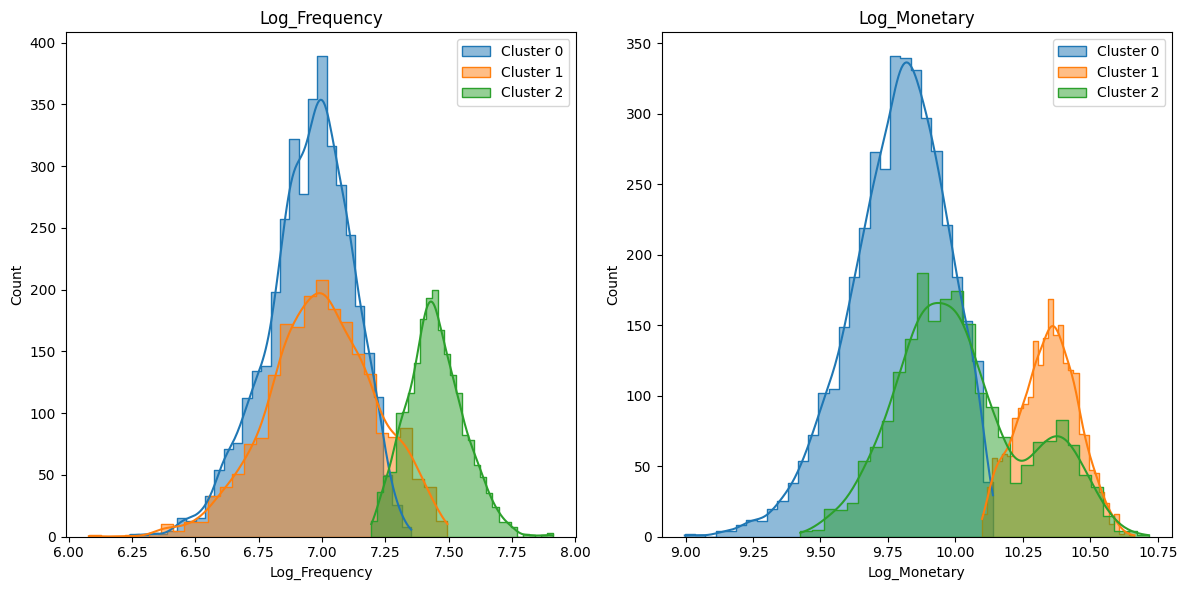

In [15]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

features = [ 'Log_Frequency', 'Log_Monetary']
for i, feature in enumerate(features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(rfm[rfm['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

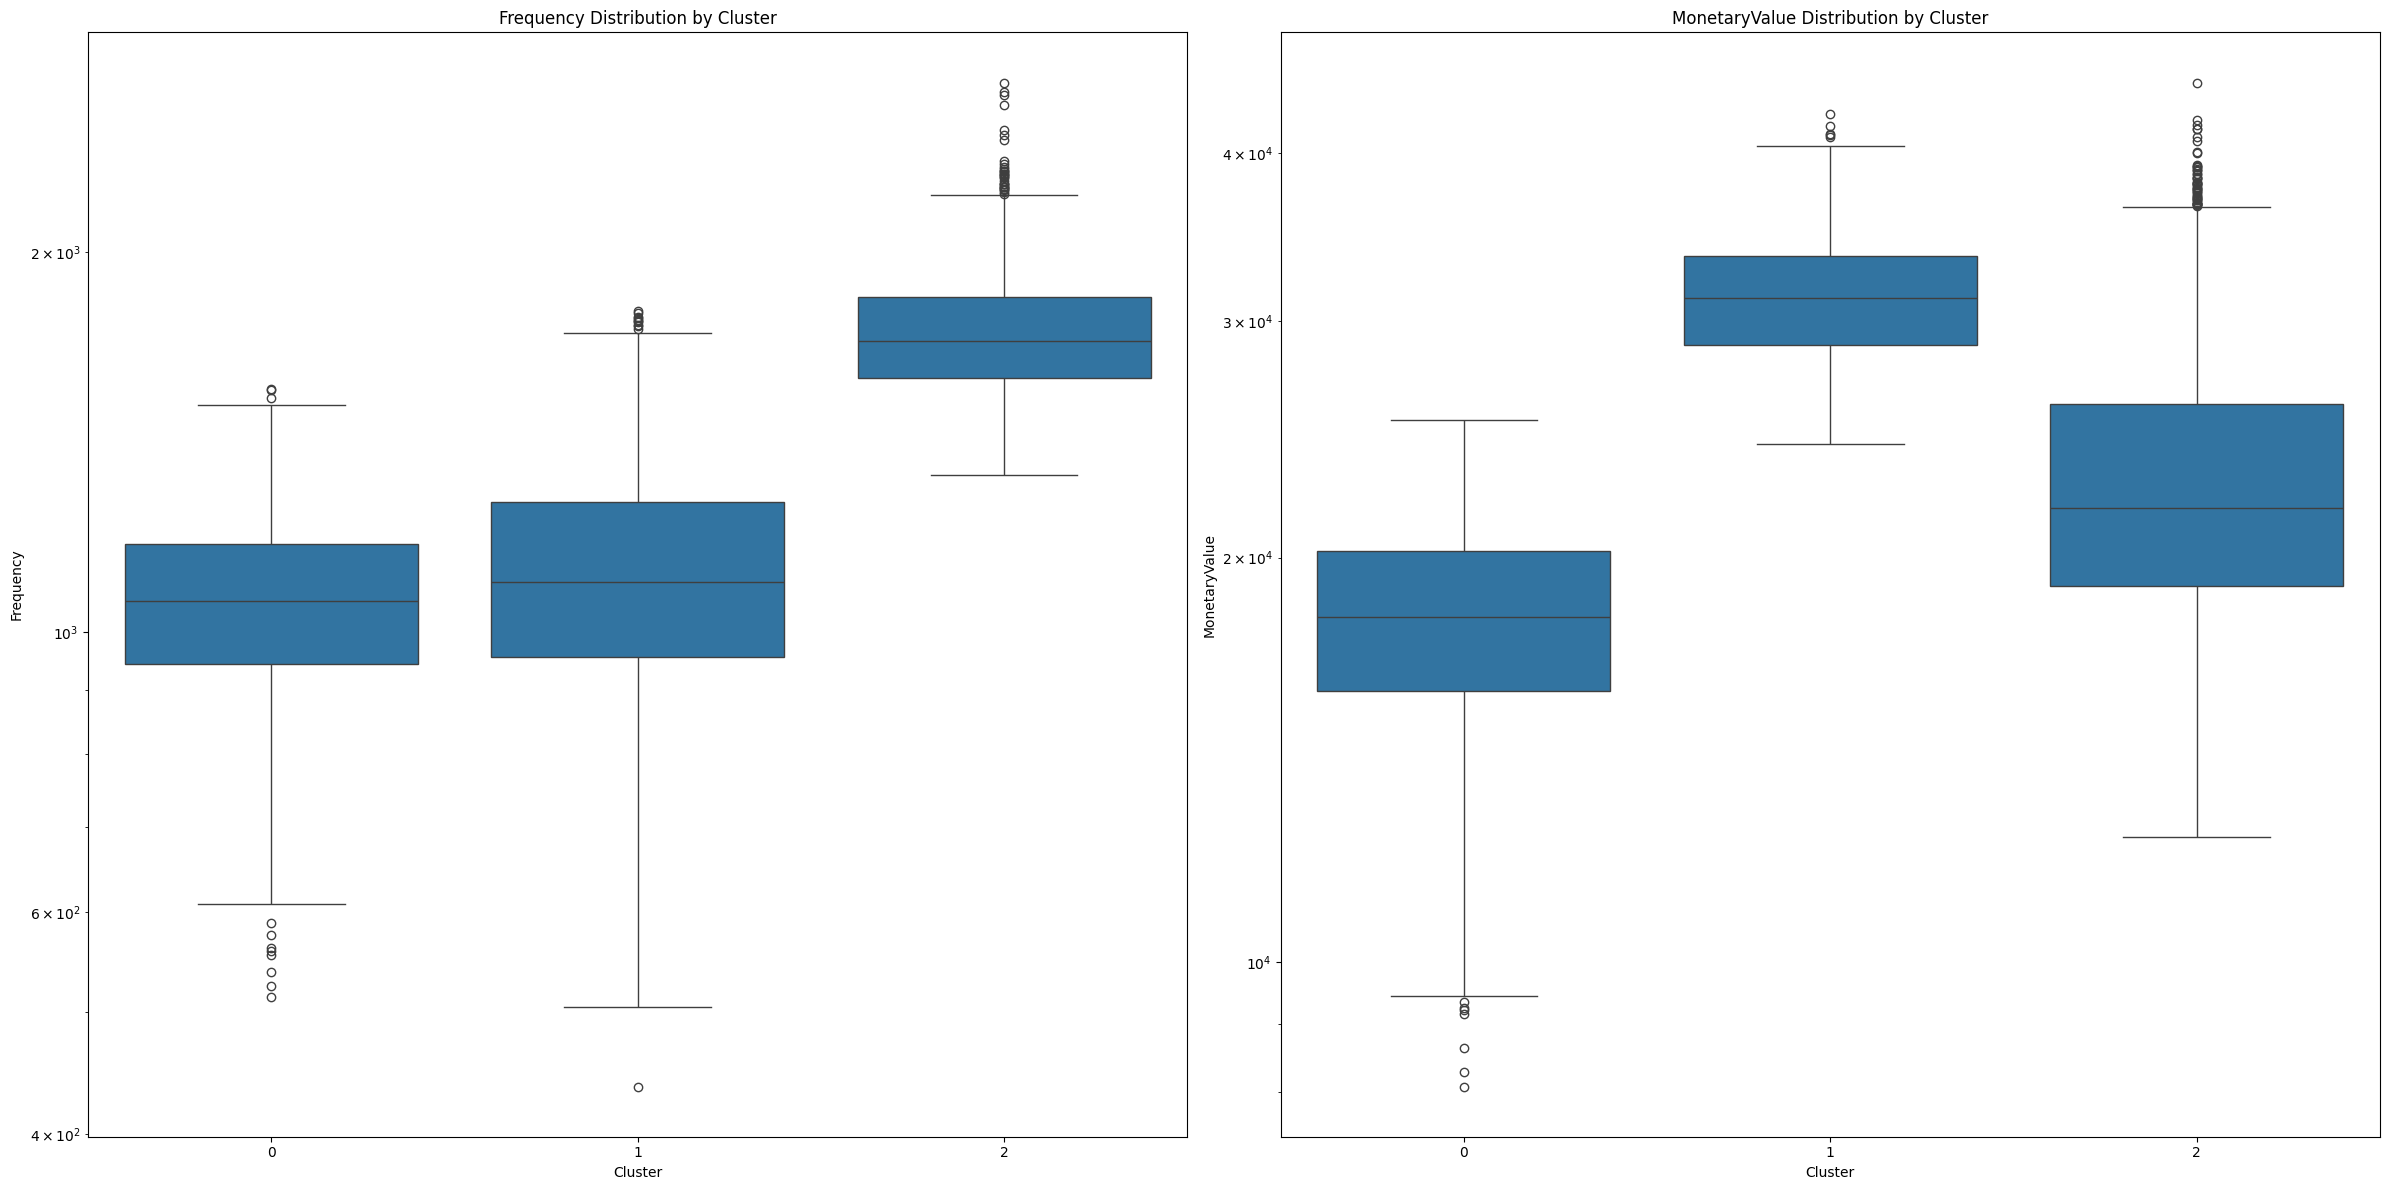

In [16]:
features = ['Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=rfm, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [17]:
merged_df = pd.merge(df2, rfm, on='AccountNumber', how='left')

print(merged_df)

          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
1               98994.0                 2.65                COFFEE_SHOP   
2               98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
3               34189.0                14.50                        BAR   
4               86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10148275        41950.0                 6.00                      21887   
10148276         8097.0                 5.00                      84802   
10148277        99012.0                 6.50                      27845   
10148278        60186.0                 2.65                      35802   
10148279        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  Frequency  \
0             2025-01-01 

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_32965/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_32965/738185343.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_32965/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_3

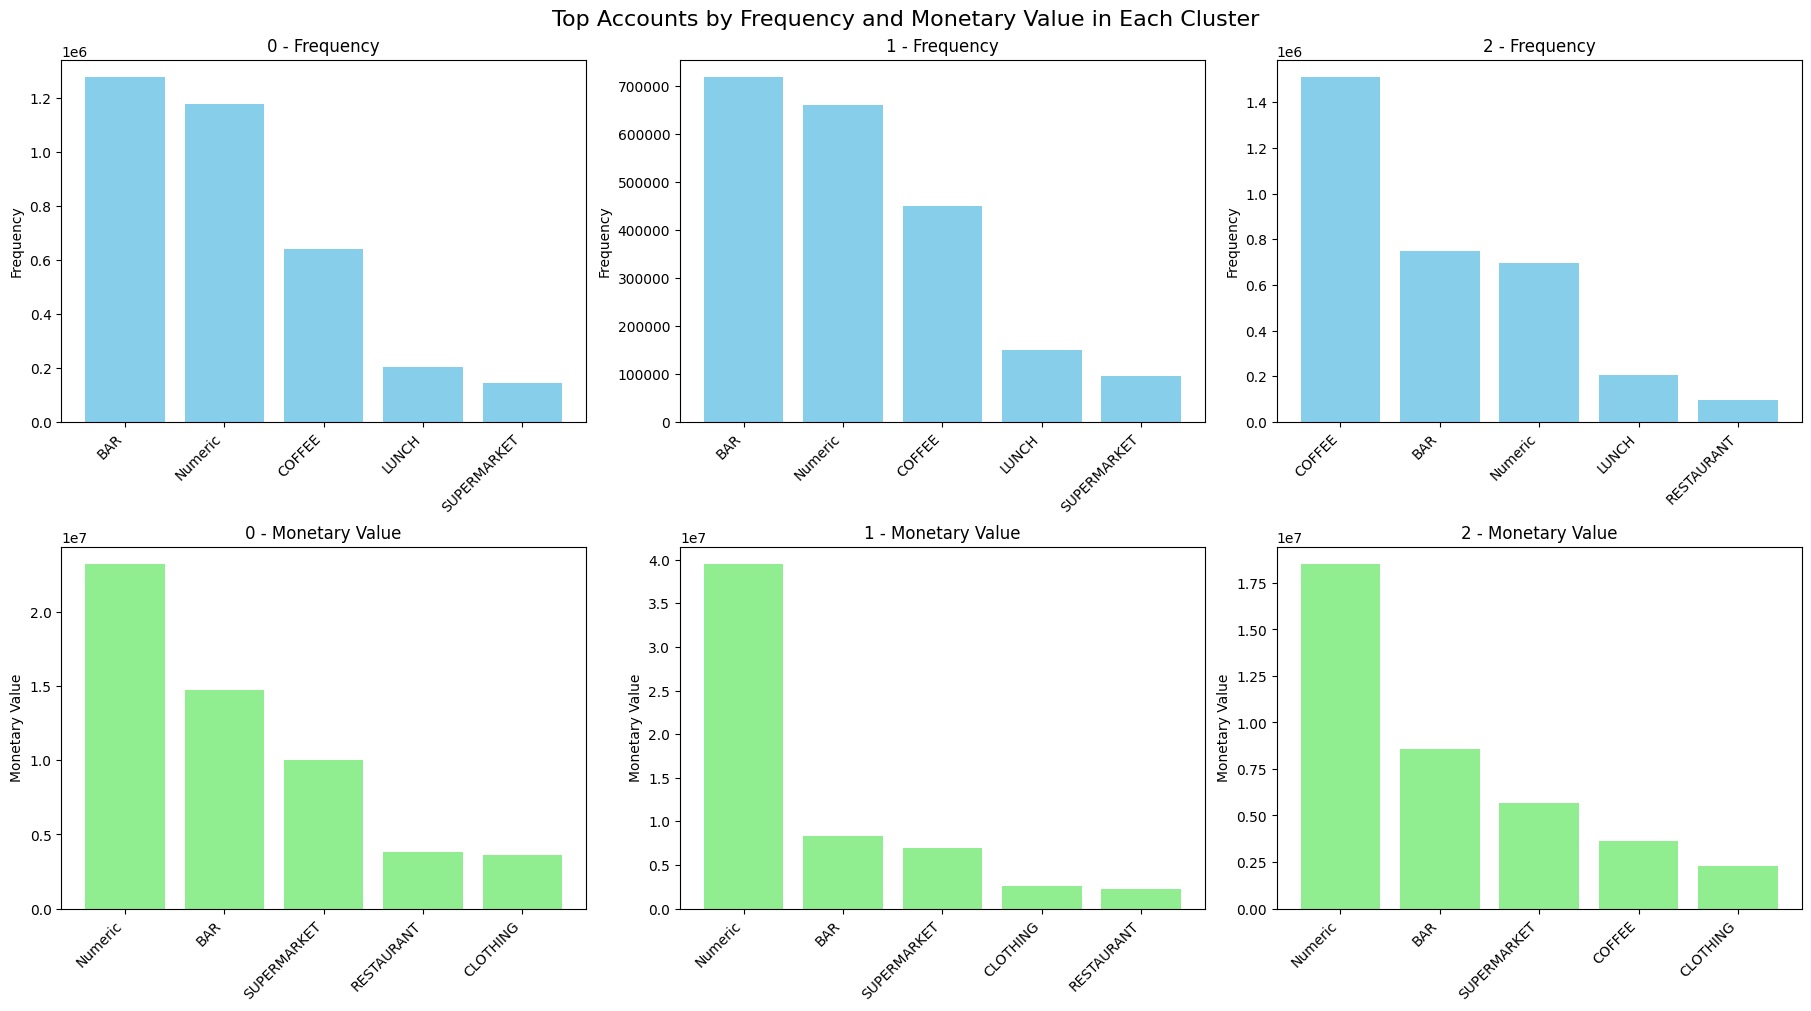

In [18]:
# Aggregating data for frequency and monetary value by cluster and account
frequency_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount']).size().reset_index(name='Frequency')
monetary_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount'])['MoneyTransferAmount'].sum().reset_index(name='MonetaryValue')

# Sorting for top accounts in each cluster by frequency
top_frequency_df = frequency_df.sort_values(by=['Cluster', 'Frequency'], ascending=[True, False]).groupby('Cluster').head(5)

# Sorting for top accounts in each cluster by monetary value
top_monetary_df = monetary_df.sort_values(by=['Cluster', 'MonetaryValue'], ascending=[True, False]).groupby('Cluster').head(5)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), constrained_layout=True)
fig.suptitle('Top Accounts by Frequency and Monetary Value in Each Cluster', fontsize=16)

clusters = merged_df['Cluster'].unique()
for i, cluster in enumerate(sorted(clusters)):
    # Frequency
    ax = axes[0, i]
    top_freq_cluster = top_frequency_df[top_frequency_df['Cluster'] == cluster]
    ax.bar(top_freq_cluster['CategoryTransferredLocationAccount'], top_freq_cluster['Frequency'], color='skyblue')
    ax.set_title(f'{cluster} - Frequency')
    ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Frequency')

    # Monetary Value
    ax = axes[1, i]
    top_monetary_cluster = top_monetary_df[top_monetary_df['Cluster'] == cluster]
    ax.bar(top_monetary_cluster['CategoryTransferredLocationAccount'], top_monetary_cluster['MonetaryValue'], color='lightgreen')
    ax.set_title(f'{cluster} - Monetary Value')
    ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Monetary Value')

plt.show()